In [99]:
import math
import numpy
import random
import pickle
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import models, Model
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib as mpl
from matplotlib import cm
from matplotlib.animation import FuncAnimation
from matplotlib.colors import ListedColormap
import multiprocessing
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
from tensorflow.keras import models, Model
import numpy as np


from numba import guvectorize,cuda
def get_mean_vector(h_set):
    """
    :param h_set: list of vectors h, each vector is output of LSTM layer at a timestep
    :return: mean vector hbar
    """
    hbar = h_set[0]
    for i in range(1, len(h_set)):
        hbar += h_set[i]
    hbar = hbar / len(h_set)
    return hbar

def get_magnitude(vector):
    """
    :param vector: 1D numpy array
    :return: magnitude of vector
    """
    magnitude = 0
    for element in vector:
        magnitude += element ** 2
    return math.sqrt(magnitude)

def get_norm(vector):
    """
    :param vector: vector to normalise
    :return: norm of vector
    """
    return vector / get_magnitude(vector)

def project(vector, basis):
    """
    :param vector: vector to project onto basis
    :param basis: basis for poincare map
    :return: vector projected onto basis (dot product)
    """
    return vector.dot(basis)

def get_poincare_mapping(lstm, start, num_steps, intermediate_inputs=None):
    """
    get poincare mapping (projections at h_t, projections at h_{t+1})
    :param lstm: trained LSTM_layer
    :param start: starting input
    :param num_steps: number of iterations to perform, length of intermediate_inputs has to be num_steps - 1
    :param intermediate_inputs: list of x_t to input at each timestep, zero vectors if None, each vector has to be length start
    :return: poincare mapping
    """
    if intermediate_inputs is None:
        intermediate_inputs = [np.zeros(len(start), dtype=np.float64) for _ in range(num_steps - 1)]

    # get h_t at each timestep
    h_t = [lstm.step(start)[-1]]
    h_t_1 = [] # h_{t+1}
    for i in range(num_steps - 1):
        curr_h = lstm.step(intermediate_inputs[i])[-1]
        h_t.append(curr_h)
        h_t_1.append(curr_h)

    h_t.pop() # remove last element so h_t and h_{t+1} aligns
    return h_t, h_t_1

def main(n):       
    # numbers setup
    class LSTM_layer():
        @staticmethod
        def sigmoid(x):
            return 1 / (1 + np.exp(-x))

        @staticmethod
        def tanh(x): # for consistency
            return np.tanh(x)
        

        def __init__(self, weights):
            """
            :param weights: weights of LSTM layer
            """
            # transposing matrices for dot product
            self.W, self.U, self.b = np.transpose(weights[0]), np.transpose(weights[1]), np.transpose(weights[2])
            self.num_units = int(self.U.shape[1])
            self.split_weights()
            # LSTM trained stateless, initial C and h are zero vectors
            self.C = np.zeros((self.num_units), dtype=np.float64)
            self.h = np.zeros((self.num_units), dtype=np.float64)

        def split_weights(self):
            # weights are stored as (neuron_num, (i, f, c, o))
            self.W_i = np.ascontiguousarray(self.W[:self.num_units, :])
            self.W_f = np.ascontiguousarray(self.W[self.num_units:self.num_units * 2, :])
            self.W_c = np.ascontiguousarray(self.W[self.num_units * 2:self.num_units * 3, :])
            self.W_o = np.ascontiguousarray(self.W[self.num_units * 3:, :])

            self.U_i = np.ascontiguousarray(self.U[:self.num_units, :])
            self.U_f = np.ascontiguousarray(self.U[self.num_units:self.num_units * 2, :])
            self.U_c = np.ascontiguousarray(self.U[self.num_units * 2:self.num_units * 3, :])
            self.U_o = np.ascontiguousarray(self.U[self.num_units * 3:, :])

            self.b_i = np.ascontiguousarray(self.b[:self.num_units])
            self.b_f = np.ascontiguousarray(self.b[self.num_units:self.num_units * 2])
            self.b_c = np.ascontiguousarray(self.b[self.num_units * 2:self.num_units * 3])
            self.b_o = np.ascontiguousarray(self.b[self.num_units * 3:])

        def step(self, x_t):
            """
            Performs a timestep (propagating new input through layer)
            :return: array of activations [ft, it, cc, cc_update, c_out, ot, ht]
            """
            activations = []
            # forget step
            ft = self.get_ft(x_t)
            activations.append(ft)
            self.forget(ft)

            # "remembering" step
            it = self.get_it(x_t)
            activations.append(it)
            cc = self.get_CC(x_t)
            activations.append(cc)
            cc_update = self.get_CC_update(it, cc)
            activations.append(cc_update)
            self.remember(cc_update)

            # output step
            c_out = self.get_C_output()
            activations.append(c_out)
            ot = self.get_ot(x_t)
            activations.append(ot)
            output = self.output(c_out, ot)
            activations.append(output)

            return activations

        def reset(self):
            # call when done with one input (with all timesteps completed)
            # resets internal cell state and starting hidden state
            self.C = np.zeros((self.num_units), dtype=np.float64)
            self.h = np.zeros((self.num_units), dtype=np.float64)


        # vectorized activation propagation
        @staticmethod
        @guvectorize(
            ["float64[:, :], float64[:, :], float64[:], float64[:], float64[:], float64[:]"],
            "(n, m),(n, n),(m),(n),(n)->(n)",
            nopython=True
        )
        def get_ft_vec(W_f, U_f, x_t, h, b_f, res):
            wfx = W_f.dot(x_t)
            ufh = U_f.dot(h)
            sum_int = wfx + ufh
            sum_f = sum_int + b_f
            res[:] = 1 / (1 + np.exp(-sum_f))

        @staticmethod
        @guvectorize(
            ["float64[:, :], float64[:, :], float64[:], float64[:], float64[:], float64[:]"],
            "(n, m),(n, n),(m),(n),(n)->(n)",
            nopython=True
        )
        def get_it_vec(W_i, U_i, x_t, h, b_i, res):
            wix = W_i.dot(x_t)
            uih = U_i.dot(h)
            sum_int = wix + uih
            sum_f = sum_int + b_i
            res[:] = 1 / (1 + np.exp(-sum_f))

        @staticmethod
        @guvectorize(
            ["float64[:, :], float64[:, :], float64[:], float64[:], float64[:], float64[:]"],
            "(n, m),(n, n),(m),(n),(n)->(n)",
            nopython=True
        )
        def get_CC_vec(W_c, U_c, x_t, h, b_c, res):
            wcx = W_c.dot(x_t)
            uch = U_c.dot(h)
            sum_int = wcx + uch
            sum_f = sum_int + b_c
            res[:] = np.tanh(sum_f)

        @staticmethod
        @guvectorize(
            ["float64[:, :], float64[:, :], float64[:], float64[:], float64[:], float64[:]"],
            "(n, m),(n, n),(m),(n),(n)->(n)",
            nopython=True
        )
        def get_ot_vec(W_o, U_o, x_t, h, b_o, res):
            wox = W_o.dot(x_t)
            uoh = U_o.dot(h)
            sum_int = wox + uoh
            sum_f = sum_int + b_o
            res[:] = 1 / (1 + np.exp(-sum_f))

        # activations start
        # tanh activations don't see an improvement from vectorization (probably because tanh is already vectorized)
        def get_ft(self, x_t):
            # sigmoid(W_f . x_t + U_f . h_(t-1) + b_f) . is dot product
            # wfx = self.W_f.dot(x_t)
            # ufh = self.U_f.dot(self.h)
            # return LSTM_layer.sigmoid(wfx + ufh + self.b_f)
            return LSTM_layer.get_ft_vec(self.W_f, self.U_f, x_t, self.h, self.b_f)

        def get_it(self, x_t):
            # sigmoid(W_i . x_t + U_i . h_(t-1) + b_i)
            # wix = self.W_i.dot(x_t)
            # uih = self.U_i.dot(self.h)
            # return LSTM_layer.sigmoid(wix + uih + self.b_i)
            return LSTM_layer.get_it_vec(self.W_i, self.U_i, x_t, self.h, self.b_i)

        def get_CC(self, x_t):
            # candidate cell state before proportion
            # tanh(W_c . x_t + U_c . h_(t-1) + b_c)
            wcx = self.W_c.dot(x_t)
            uch = self.U_c.dot(self.h)
            return LSTM_layer.tanh(wcx + uch + self.b_c)
            # return LSTM_layer.get_CC_vec(self.W_c, self.U_c, x_t, self.h, self.b_c)

        def get_ot(self, x_t):
            # sigmoid(W_o . x_t + U_o . h_(t-1) + b_o)
            # wox = self.W_o.dot(x_t)
            # uoh = self.U_o.dot(self.h)
            # return LSTM_layer.sigmoid(wox + uoh + self.b_o)
            return LSTM_layer.get_ot_vec(self.W_o, self.U_o, x_t, self.h, self.b_o)

        def get_C_output(self):
            # cell state output before proportion
            # tanh(C_t)
            return LSTM_layer.tanh(self.C)

        def get_CC_update(self, it, cc):
            # candidate cell state after proportion, for updating cell state
            # it * cc, * is Hadamard product
            return it * cc
        # activations end


        # state updates start
        def forget(self, ft):
            # update old cell state in the forget step
            self.C = self.C * ft

        def remember(self, cc_update):
            # update old cell state with new information
            self.C = self.C + cc_update

        def output(self, c_output, ot):
            # proportionate the cell output vector for new output and hidden state
            self.h = c_output * ot
            return self.h
    
    num_timesteps = 500
    len_sequence = 75000
    start_count = 0 #99500
    end_point = 75000
    num_cells = 60
    
    
    if n<10:
        filepath='ineight/'+'weights.0'+str(n)+'.hdf5' 
    else:
        filepath= 'ineight/'+'weights.'+str(n)+'.hdf5'  
    
    model= models.load_model(filepath,compile=False)
    
    embed_layer = Model(inputs=model.input, outputs=model.layers[0].output)
    
    
    #print(len(x))
    lstm_made=xl[0:500]
    lstm_in=[lstm_made]
    lstm_in_gau=[]
    for i in range(500):
        lstm_in_gau.append(xl[i])
    lstm_in_gau=[lstm_in_gau]
        #x_in=np.zeros((1,500),int).tolist()
        # print(length[i])
        # if length[i] < 350:
        #     continue
        #x_in_gau = x[i].reshape((1, num_timesteps))+ random.gauss(0,1e-15)
        #x_in_gau = x_in + random.gauss(0,0.0001)
        #print(x_in[0])
        #print(x_in_gau)
        #print(lstm_in.dtype)
        #for i in range(0,500):
            #lstm_in[0][i]=np.float64(np.zeros((32,)))
        #lstm_in_late[0][0][0]=0.01
        #print(lstm_in_late)
        #for i in range(0,500):
            #lstm_in_gau[0][i]=np.float64(np.zeros((32,)))
        #print(lstm_in_gau.dtype,lstm_in_gau)
        #lstm_in_late_gau[0][0][0]=0.01
    lstm_in_gau[0][0]=lstm_in_gau[0][0]+np.float64(random.gauss(0,1e-6))
    a=model.layers[1].get_weights()
    for i in range(len(a)):
        if i!=2:
            a[i]=np.float64(a[i])
        else:
            a[i]=a[i][0:240]+a[i][240:]
            a[i]=np.float64(a[i])
            #print(a[i].dtype)
    lstm = LSTM_layer(a)
    start = lstm_in[0][0]
    #print(np.array(start).shape)
    start_gau=lstm_in_gau[0][0]
        #print(lstm_in_late)
        #print(start,start_gau)
    intermediate_steps=xl[500:]
    
        

        
    h_t_late, h_t_1_late = get_poincare_mapping(lstm, start, len_sequence, intermediate_steps)
    h_t_late.append(h_t_1_late[-1])
    hbar_late = get_mean_vector(h_t_late)
        
    h_t_late_gau, h_t_1_late_gau = get_poincare_mapping(lstm, start_gau, len_sequence, intermediate_steps)
        #print(h_t_late_gau[0])
    h_t_late_gau.append(h_t_1_late_gau[-1])
    late_set=[]

        #print(len(h_t_late_gau))
        #print(len(h_t_late))
    for j in range(len(h_t_late)-10, len(h_t_late)):

            vec1=np.array(h_t_late[j])
            vec2=np.array(h_t_late_gau[j])
            dist = np.float64(numpy.linalg.norm(vec1 - vec2))
            #if dist<=np.finfo(np.float32).eps:
                #dist=np.float32(0)
            dist_late=np.float64(numpy.log(dist+numpy.exp(-25)))
            
            late_set.append(dist_late)
    print(n,n,np.mean(late_set))   
    return np.mean(late_set)
        #if np.mean(late)<=np.float32(np.log(np.finfo(np.float32).eps)):
            #me=np.float32(-25)
        
         
        #plt.figure(figsize=(15,8)) 
        #plt.scatter(np.arange(len(late)),late,c='blue')
        #plt.scatter(h_t_late_gau[0:-2],h_t_late_gau[1:-1],c='grey')
        #plt.plot(h_t_late[-2],h_t_late[-1],'d',c='yellow')
        #plt.plot(h_t_late_gau[-2],h_t_late[-1],'s',c='orange')
        #plt.ylim(-30,2,32)
        #plt.xlabel('len_sequence')
        #plt.ylabel('log distance between ht` and ht')
        #plt.plot(h_t_late_gau[-2],h_t_late_gau[-1],'s',c='green')
        #plt.legend()
        #plt.savefig('LSTM70/str(n)_multiplier.png')
        #plt.title('distance of the optimal epoch')
        #a=str(n)+''+'opt'+'-'+'times'+'-'+'multilier'
        #plt.savefig(os.path.join('lstmmmmmmmm', a+'.png' ))
        #plt.show()
        
        
    
if __name__ == "__main__":
    xl1=[]
    for i in range(1000):
        xl1.append(main(i+1))
    np.savetxt('ineight/newmodel.txt',xl1)
        #main(1000)
    #pool.close() 
    #pool.join()
    


1 1 -25.0
2 2 -25.0
3 3 -25.0
4 4 -25.0
5 5 -25.0
6 6 -25.0
7 7 -25.0
8 8 -25.0
9 9 -25.0
10 10 -25.0
11 11 -25.0
12 12 -25.0
13 13 -25.0
14 14 -25.0
15 15 -25.0
16 16 -25.0
17 17 -25.0
18 18 -25.0
19 19 -25.0
20 20 -25.0
21 21 -25.0
22 22 -25.0
23 23 -25.0
24 24 -25.0
25 25 -25.0
26 26 -24.999988197193723
27 27 -25.0
28 28 -25.0
29 29 -24.99998606850243
30 30 -25.0
31 31 -25.0
32 32 -25.0
33 33 -25.0
34 34 -24.999984898878456
35 35 -24.99999253072874
36 36 -24.999988282015586
37 37 -24.999995473699656
38 38 -25.0
39 39 -24.999994012529577
40 40 -24.999991821132724
41 41 -24.999992116356403
42 42 -24.99999400145831
43 43 -24.999988220476645
44 44 -24.999989269577092
45 45 -24.999991315815098
46 46 -24.999992498611256
47 47 -24.999986154942285
48 48 -24.999992417756623
49 49 -24.999990060233163
50 50 -24.99998910999263
51 51 -24.999991575904453
52 52 -24.999990815366708
53 53 -24.999984837081854
54 54 -24.999992503231518
55 55 -24.99998558651351
56 56 -24.999989926902288
57 57 -24.99999

In [109]:
l=0
intermediate_steps=[]
while l<1:
        intermediate_steps+=np.float64(np.random.normal(0,1,size=500*32)).reshape((500,32)).tolist()
        l+=1
np.savetxt('papercon/fir.txt',intermediate_steps)

In [72]:
xl=[]
with open('papercon/inde.txt') as f:
    for line in f.readlines():
        line=[np.float64(line.strip('\n').split()[i]) for i in range(len(line.strip('\n').split()))]
        xl.append(line )
np.shape(xl)

(75500, 32)

In [54]:
path='inzero/'+'weights.0'+str(9)+'.hdf5'
model=tf.keras.models.load_model(path)
weights = model.layers[1].get_weights()
weights[2]=weights[2][0:240]+weights[2][240:]
len(weights[2])

240

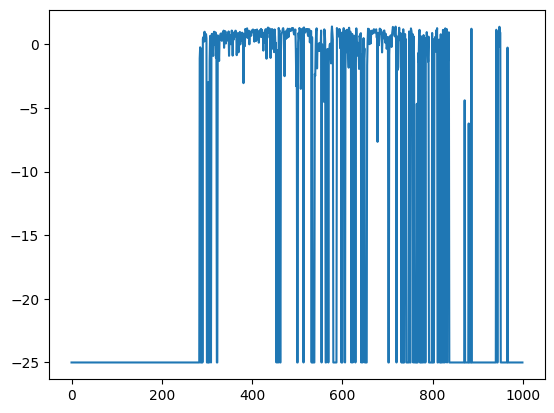

In [96]:
plt.plot(xl1)

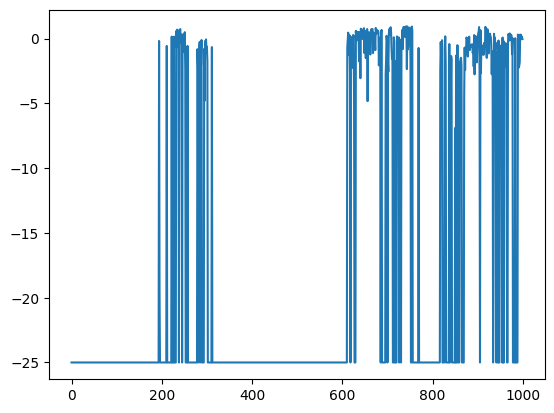

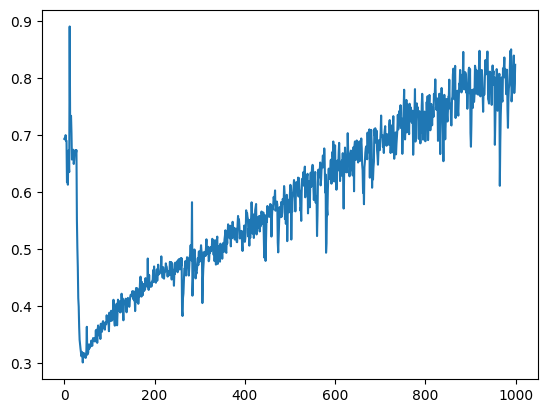

In [89]:
plt.plot(xl1)
plt.show()
axias=[]
with open('inthree/summary.txt') as f:
    for line in f.readlines():
        line=np.float64(line.strip('\n').split())
        axias.append(line[3])
plt.plot(axias)
plt.show()